<a href="https://colab.research.google.com/github/mikulskibartosz/RNN_workshop/blob/main/rnn_workshop_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Ładowanie danych

In [2]:
r = requests.get('https://raw.githubusercontent.com/mikulskibartosz/RNN_workshop/main/visitors.csv%20-%20Sheet1.csv', allow_redirects=True)
with open('data.csv', 'wb') as f:
  f.write(r.content)

In [3]:
data = pd.read_csv('data.csv')

In [4]:
data.head()

,date,visitors
0,1/1/20,262
1,1/2/20,680
2,1/3/20,616
3,1/4/20,352
4,1/5/20,399


In [5]:
data['date'] = pd.to_datetime(data.date)

data['visitors'] = data['visitors'].str.replace(',', '')
data['visitors'] = data['visitors'].astype(int)

# Eksploracja danych

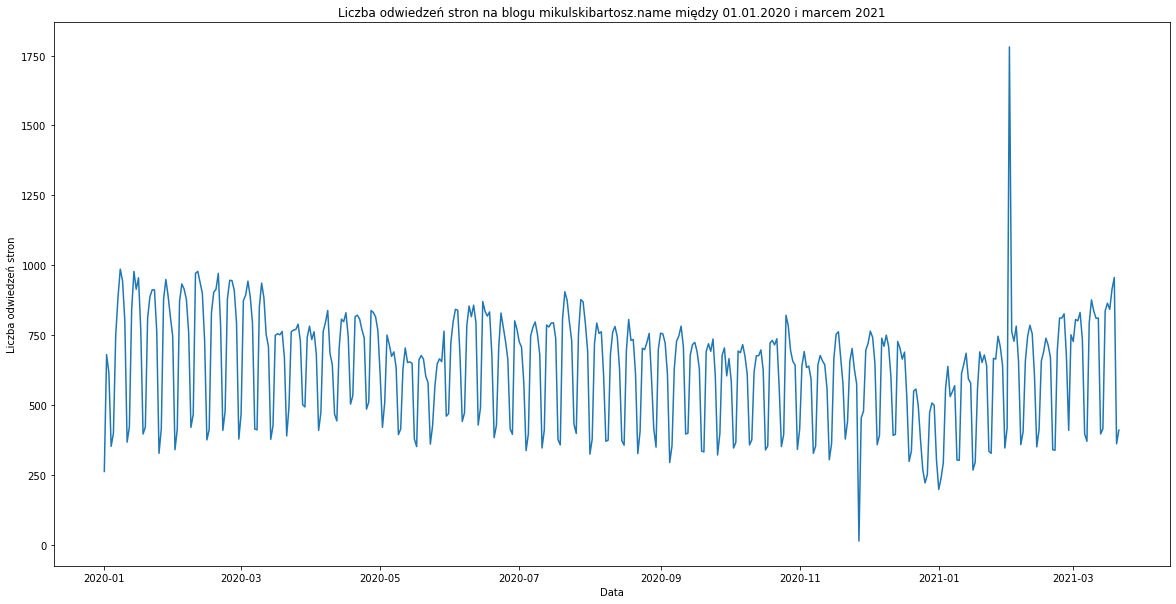

In [6]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(data.date, data.visitors)
plt.xlabel('Data')
plt.ylabel('Liczba odwiedzeń stron')
plt.title('Liczba odwiedzeń stron na blogu mikulskibartosz.name między 01.01.2020 i marcem 2021')
plt.show()

In [7]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
visitors,446.0,634.473094,196.327834,13.0,441.0,678.5,768.0,1781.0


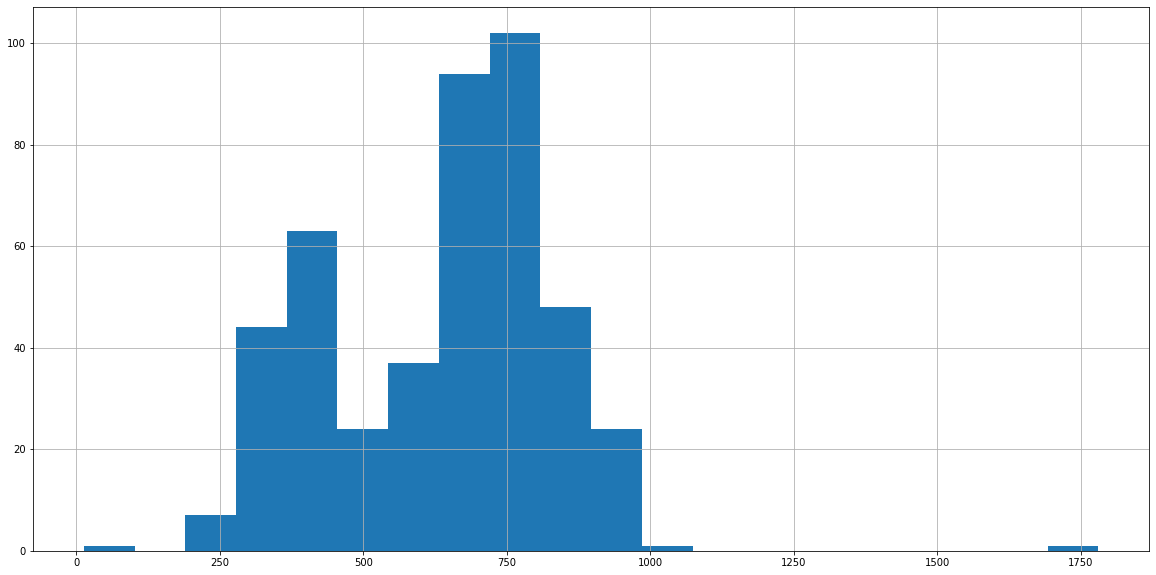

In [8]:
data.visitors.hist(bins=20)

## Outlier detection (tylko gdy rozkład Gaussa)

https://www.mikulskibartosz.name/outlier-detection-with-scikit-learn/

https://www.ztable.net/

Fix the mistake in the article

In [9]:
from scipy.stats import zscore
visitor_zscores = zscore(data.visitors)
visitor_outliers = pd.Series(visitor_zscores).apply(
  lambda x: x <= -2.5 or x >= 2.5
)
data[visitor_outliers]

,date,visitors
331,2020-11-27,13
397,2021-02-01,1781


## Znajdowanie cykli/sezonowości

Fast Fourier Transform

Znajdowanie częstotliwości składowych sygnału - powinniśmy przeskalować do średniej = 0

ale zadziała też bez przeskalowania

w tym przypadku częstotliwościami składowymi są cykle/sezonowość w danych

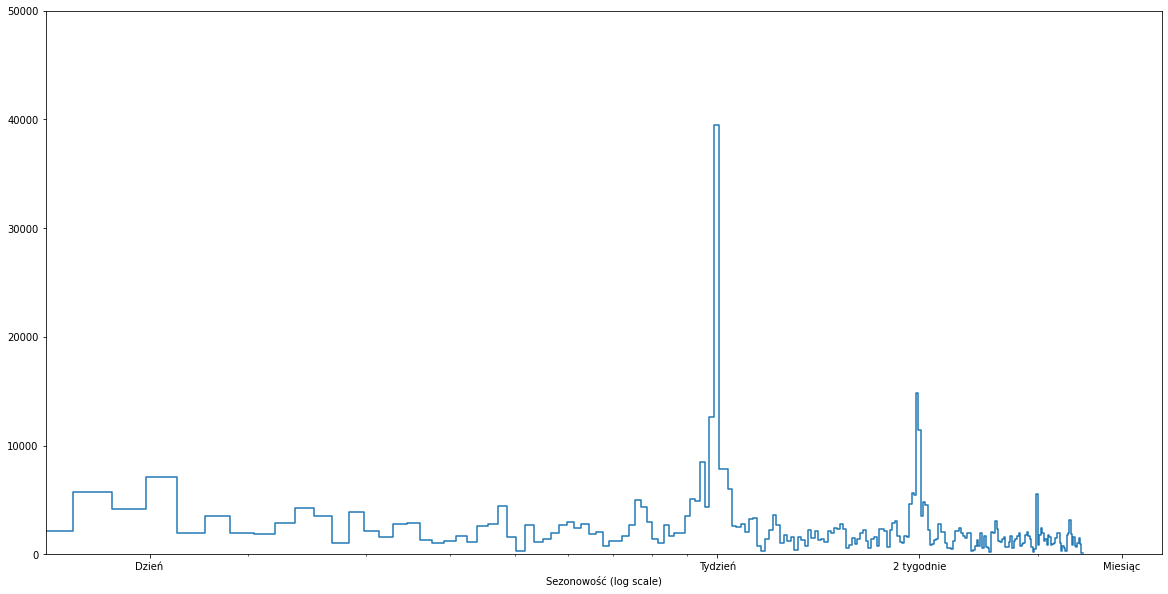

In [10]:
fft = tf.signal.rfft(data['visitors'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(data['visitors'])
weeks_per_dataset = n_samples_h/(7)

f_per_year = f_per_dataset/weeks_per_dataset # sampling frequency

plt.step(f_per_year, np.abs(fft)) # plot(x, y) z kątami prostymi
plt.xscale('log')
plt.ylim(0, 50000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1.0/7, 1, 2, 4], labels=['Dzień', 'Tydzień', '2 tygodnie', 'Miesiąc'])
_ = plt.xlabel('Sezonowość (log scale)')

# Feature Engineering

Dni tygodnia jako sin/cos

In [11]:
data['day_of_week'] = data.date.dt.weekday

In [12]:
# angular distance between days of weeks
data['day_of_week_sin'] = np.sin(data['day_of_week'] * (2 * np.pi / 7))
data['day_of_week_cos'] = np.cos(data['day_of_week'] * (2 * np.pi / 7))

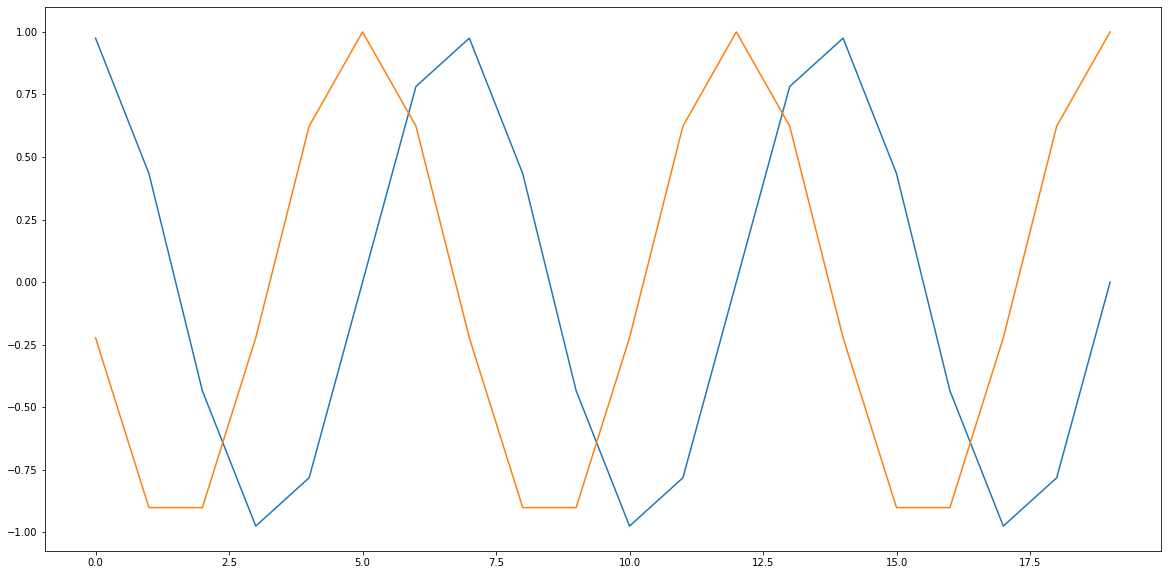

In [13]:
plt.plot(data['day_of_week_sin'][:20])
plt.plot(data['day_of_week_cos'][:20])

## Weekendy

In [14]:
data['is_weekend'] = data['day_of_week'].isin([5, 6])

## Dni miesiąca

In [15]:
data['day_of_month'] = data.date.dt.day
data['day_of_month_sin'] = np.sin(data['day_of_month'] * (2 * np.pi / 7))
data['day_of_month_cos'] = np.cos(data['day_of_month'] * (2 * np.pi / 7))

# Outliers

In [16]:
data[394:400]

,date,visitors,day_of_week,day_of_week_sin,day_of_week_cos,is_weekend,day_of_month,day_of_month_sin,day_of_month_cos
394,2021-01-29,641,4,-0.433884,-0.900969,False,29,0.781831,0.623490
395,2021-01-30,346,5,-0.974928,-0.222521,True,30,0.974928,-0.222521
396,2021-01-31,418,6,-0.781831,0.623490,True,31,0.433884,-0.900969
397,2021-02-01,1781,0,0.000000,1.000000,False,1,0.781831,0.623490
398,2021-02-02,763,1,0.781831,0.623490,False,2,0.974928,-0.222521
399,2021-02-03,728,2,0.974928,-0.222521,False,3,0.433884,-0.900969


In [17]:
data.loc[data['visitors'] == 1781, 'visitors']  = (641+763+728) / 3

In [18]:
data[326:335]

,date,visitors,day_of_week,day_of_week_sin,day_of_week_cos,is_weekend,day_of_month,day_of_month_sin,day_of_month_cos
326,2020-11-22,441.0,6,-0.781831,0.623490,True,22,7.818315e-01,0.623490
327,2020-11-23,656.0,0,0.000000,1.000000,False,23,9.749279e-01,-0.222521
328,2020-11-24,702.0,1,0.781831,0.623490,False,24,4.338837e-01,-0.900969
329,2020-11-25,628.0,2,0.974928,-0.222521,False,25,-4.338837e-01,-0.900969
330,2020-11-26,575.0,3,0.433884,-0.900969,False,26,-9.749279e-01,-0.222521
331,2020-11-27,13.0,4,-0.433884,-0.900969,False,27,-7.818315e-01,0.623490
332,2020-11-28,454.0,5,-0.974928,-0.222521,True,28,-9.797174e-16,1.000000
333,2020-11-29,478.0,6,-0.781831,0.623490,True,29,7.818315e-01,0.623490
334,2020-11-30,696.0,0,0.000000,1.000000,False,30,9.749279e-01,-0.222521


In [19]:
data.loc[data['visitors'] == 13, 'visitors']  = (628 + 575 + 454 + 478) / 4

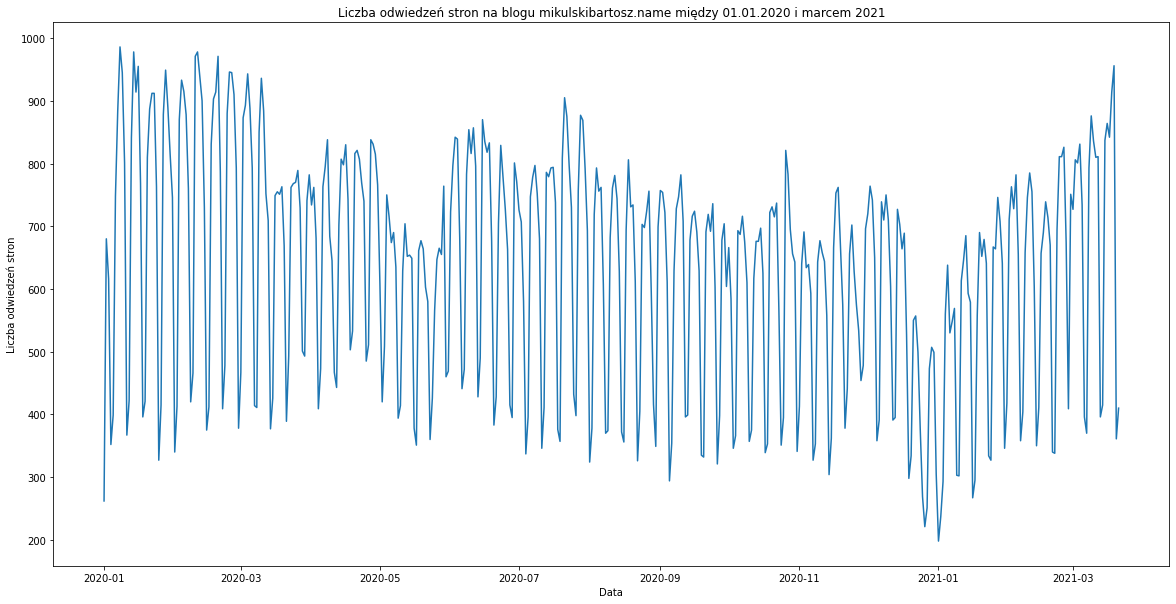

In [20]:
plt.plot(data.date, data.visitors)
plt.xlabel('Data')
plt.ylabel('Liczba odwiedzeń stron')
plt.title('Liczba odwiedzeń stron na blogu mikulskibartosz.name między 01.01.2020 i marcem 2021')
plt.show()

# Features - wybór parametrów dla modelu

In [21]:
features = data[['visitors', 'day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin', 'day_of_month_cos', 'is_weekend']]

# Train/validate/test

In [22]:
n = len(features)
train_df = features[0:int(n*0.7)]
val_df = features[int(n*0.7):int(n*0.9)]
test_df = features[int(n*0.9):]

num_features = features.shape[1]

Maksymalny zakres w czasie testów!!!

In [23]:
test_df.shape

(45, 6)

# Normalizacja

Pamiętać żeby wyjaśnić dlaczego tylko train_mean, train_std

In [24]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

## Helper class

In [25]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result


  def plot(self, model=None, plot_col='visitors', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Days')

In [26]:
INPUT_WIDTH = 30

In [27]:
single_step_window = WindowGenerator(
    input_width=INPUT_WIDTH, label_width=INPUT_WIDTH, shift=1,
    label_columns=['visitors'])
single_step_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['visitors']

In [28]:
val_performance = {}
performance = {}

## "Linear" model

In [29]:
baseline = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [30]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [31]:
history = compile_and_fit(baseline, single_step_window)

val_performance['Linear'] = baseline.evaluate(single_step_window.val)
performance['Linear'] = baseline.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
9/9 [==============================] - 1s 78ms/step - loss: 2.6866 - mean_absolute_error: 1.3689 - val_loss: 2.7134 - val_mean_absolute_error: 1.3676
Epoch 2/20
9/9 [==============================] - 0s 13ms/step - loss: 2.5651 - mean_absolute_error: 1.3384 - val_loss: 2.6219 - val_mean_absolute_error: 1.3444
Epoch 3/20
9/9 [==============================] - 0s 15ms/step - loss: 2.5171 - mean_absolute_error: 1.3235 - val_loss: 2.5333 - val_mean_absolute_error: 1.3215
Epoch 4/20
9/9 [==============================] - 0s 12ms/step - loss: 2.4087 - mean_absolute_error: 1.2936 - val_loss: 2.4468 - val_mean_absolute_error: 1.2986
Epoch 5/20
9/9 [==============================] - 0s 13ms/step - loss: 2.2696 - mean_absolute_error: 1.2552 - val_loss: 2.3636 - val_mean_absolute_error: 1.2762
Epoch 6/20
9/9 [==============================] - 0s 14ms/step - loss: 2.2005 - mean_absolute_error: 1.2329 - val_loss: 2.2827 - val_mean_absolute_error: 1.2540
Epoch 7/20
9/9 [==================

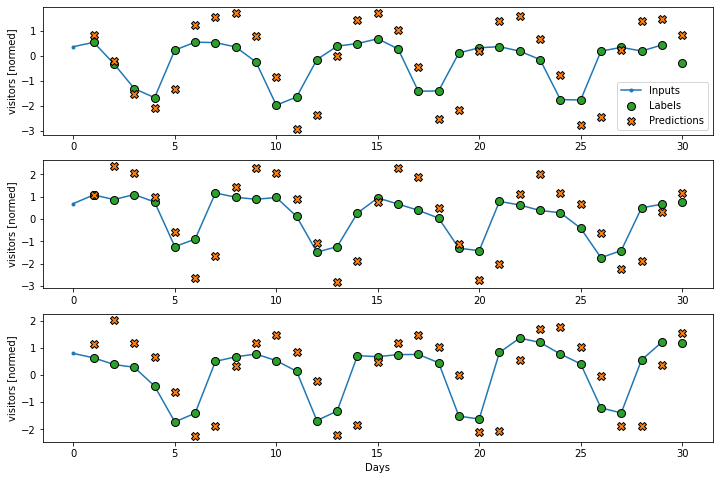

In [32]:
single_step_window.plot(baseline)

In [33]:
baseline.predict(single_step_window.test)[0][0] * train_std + train_mean

visitors            733.821135
day_of_week_sin       0.303676
day_of_week_cos       0.295918
day_of_month_sin      0.366982
day_of_month_cos      0.296417
is_weekend            0.479002
dtype: float64

## Dense model

Epoch 1/20
9/9 [==============================] - 1s 38ms/step - loss: 0.7368 - mean_absolute_error: 0.7270 - val_loss: 0.5983 - val_mean_absolute_error: 0.6069
Epoch 2/20
9/9 [==============================] - 0s 17ms/step - loss: 0.4017 - mean_absolute_error: 0.5063 - val_loss: 0.4789 - val_mean_absolute_error: 0.5586
Epoch 3/20
9/9 [==============================] - 0s 15ms/step - loss: 0.2177 - mean_absolute_error: 0.3720 - val_loss: 0.4168 - val_mean_absolute_error: 0.5184
Epoch 4/20
9/9 [==============================] - 0s 15ms/step - loss: 0.1431 - mean_absolute_error: 0.3011 - val_loss: 0.3594 - val_mean_absolute_error: 0.4756
Epoch 5/20
9/9 [==============================] - 0s 16ms/step - loss: 0.1080 - mean_absolute_error: 0.2622 - val_loss: 0.3178 - val_mean_absolute_error: 0.4402
Epoch 6/20
9/9 [==============================] - 0s 15ms/step - loss: 0.0847 - mean_absolute_error: 0.2314 - val_loss: 0.2730 - val_mean_absolute_error: 0.4040
Epoch 7/20
9/9 [==================

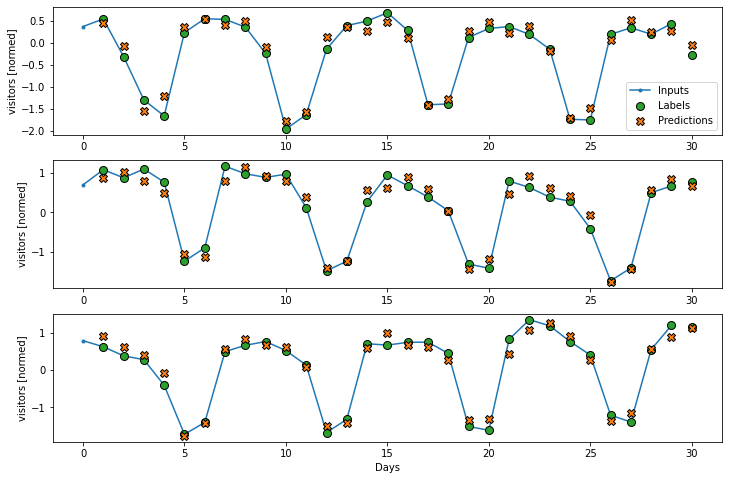

In [34]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)
single_step_window.plot(dense)

## LSTM model

In [35]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(512, return_sequences=True, activation="tanh"),
    tf.keras.layers.Dropout(0.4),
    # tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

Epoch 1/20
9/9 [==============================] - 7s 500ms/step - loss: 0.7869 - mean_absolute_error: 0.7281 - val_loss: 0.4603 - val_mean_absolute_error: 0.5401
Epoch 2/20
9/9 [==============================] - 4s 444ms/step - loss: 0.1815 - mean_absolute_error: 0.3295 - val_loss: 0.4297 - val_mean_absolute_error: 0.4759
Epoch 3/20
9/9 [==============================] - 4s 445ms/step - loss: 0.1162 - mean_absolute_error: 0.2649 - val_loss: 0.3289 - val_mean_absolute_error: 0.4192
Epoch 4/20
9/9 [==============================] - 4s 436ms/step - loss: 0.0874 - mean_absolute_error: 0.2317 - val_loss: 0.2993 - val_mean_absolute_error: 0.3742
Epoch 5/20
9/9 [==============================] - 4s 443ms/step - loss: 0.0747 - mean_absolute_error: 0.2122 - val_loss: 0.2727 - val_mean_absolute_error: 0.3537
Epoch 6/20
9/9 [==============================] - 4s 438ms/step - loss: 0.0700 - mean_absolute_error: 0.2071 - val_loss: 0.2590 - val_mean_absolute_error: 0.3457
Epoch 7/20
9/9 [============

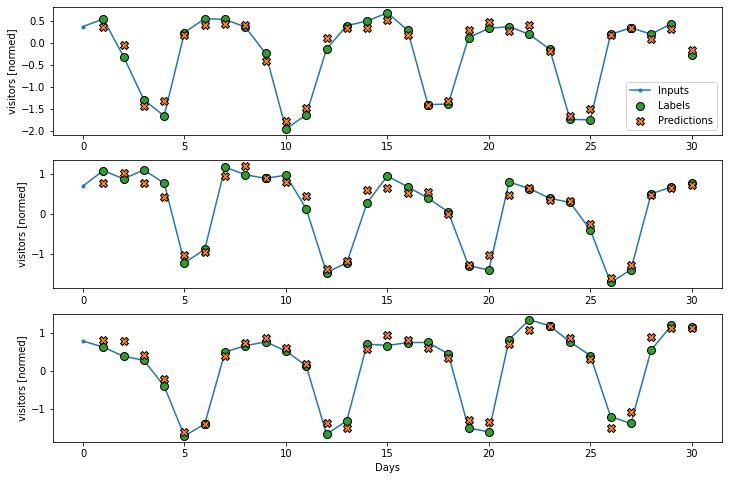

In [36]:
history = compile_and_fit(lstm_model, single_step_window)
val_performance['LSTM'] = dense.evaluate(single_step_window.val)
performance['LSTM'] = dense.evaluate(single_step_window.test, verbose=0)
single_step_window.plot(lstm_model)

## Two week prediction

In [37]:
val_performance_two_weeks = {}
performance_two_weeks = {}

In [38]:
OUT_STEPS = 14
def fit_model_and_update_stats_multi_output(model, model_name):
  model_selection_training_window = WindowGenerator(
    input_width=30, label_width=OUT_STEPS, shift=OUT_STEPS,
    label_columns=['visitors'])

  history = compile_and_fit(model, model_selection_training_window)

  val_performance_two_weeks[model_name] = model.evaluate(model_selection_training_window.val)
  performance_two_weeks[model_name] = model.evaluate(model_selection_training_window.test, verbose=0)
  model_selection_training_window.plot(model)

Epoch 1/20
9/9 [==============================] - 1s 59ms/step - loss: 0.8963 - mean_absolute_error: 0.7942 - val_loss: 1.5652 - val_mean_absolute_error: 0.9647
Epoch 2/20
9/9 [==============================] - 0s 16ms/step - loss: 0.8692 - mean_absolute_error: 0.7819 - val_loss: 1.5427 - val_mean_absolute_error: 0.9587
Epoch 3/20
9/9 [==============================] - 0s 11ms/step - loss: 0.8336 - mean_absolute_error: 0.7593 - val_loss: 1.5207 - val_mean_absolute_error: 0.9532
Epoch 4/20
9/9 [==============================] - 0s 18ms/step - loss: 0.8103 - mean_absolute_error: 0.7493 - val_loss: 1.4992 - val_mean_absolute_error: 0.9483
Epoch 5/20
9/9 [==============================] - 0s 17ms/step - loss: 0.8030 - mean_absolute_error: 0.7469 - val_loss: 1.4796 - val_mean_absolute_error: 0.9443
Epoch 6/20
9/9 [==============================] - 0s 15ms/step - loss: 0.7679 - mean_absolute_error: 0.7279 - val_loss: 1.4609 - val_mean_absolute_error: 0.9407
Epoch 7/20
9/9 [==================

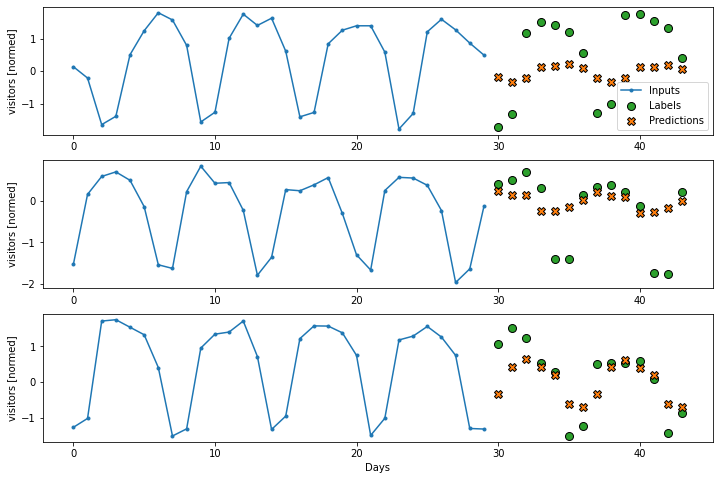

In [39]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

fit_model_and_update_stats_multi_output(multi_linear_model, 'multi_linear')

Epoch 1/20
9/9 [==============================] - 1s 40ms/step - loss: 0.8707 - mean_absolute_error: 0.7792 - val_loss: 1.4513 - val_mean_absolute_error: 0.9445
Epoch 2/20
9/9 [==============================] - 0s 14ms/step - loss: 0.6541 - mean_absolute_error: 0.6653 - val_loss: 1.3400 - val_mean_absolute_error: 0.9373
Epoch 3/20
9/9 [==============================] - 0s 17ms/step - loss: 0.4519 - mean_absolute_error: 0.5497 - val_loss: 1.2220 - val_mean_absolute_error: 0.9134
Epoch 4/20
9/9 [==============================] - 0s 16ms/step - loss: 0.3319 - mean_absolute_error: 0.4655 - val_loss: 1.1130 - val_mean_absolute_error: 0.8774
Epoch 5/20
9/9 [==============================] - 0s 17ms/step - loss: 0.2639 - mean_absolute_error: 0.4149 - val_loss: 1.0573 - val_mean_absolute_error: 0.8533
Epoch 6/20
9/9 [==============================] - 0s 16ms/step - loss: 0.2527 - mean_absolute_error: 0.4046 - val_loss: 1.0619 - val_mean_absolute_error: 0.8571
Epoch 7/20
9/9 [==================

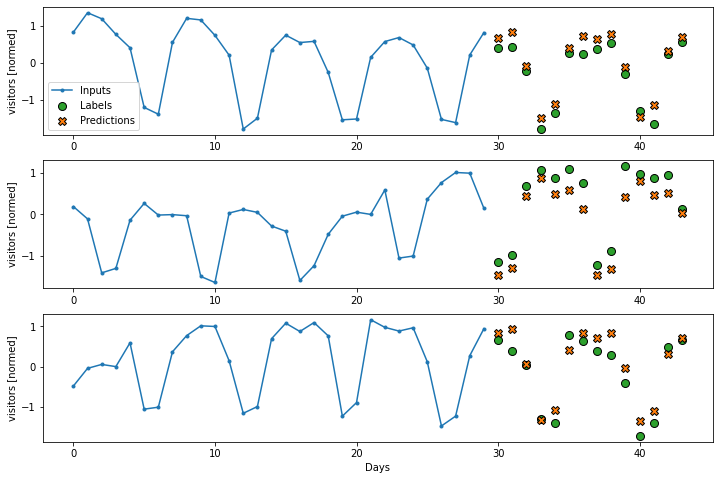

In [40]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
fit_model_and_update_stats_multi_output(multi_dense_model, 'multi_dense')

Epoch 1/20
9/9 [==============================] - 3s 85ms/step - loss: 0.9101 - mean_absolute_error: 0.7962 - val_loss: 1.5694 - val_mean_absolute_error: 0.9649
Epoch 2/20
9/9 [==============================] - 0s 25ms/step - loss: 0.9042 - mean_absolute_error: 0.7997 - val_loss: 1.5468 - val_mean_absolute_error: 0.9576
Epoch 3/20
9/9 [==============================] - 0s 25ms/step - loss: 0.8532 - mean_absolute_error: 0.7666 - val_loss: 1.5172 - val_mean_absolute_error: 0.9484
Epoch 4/20
9/9 [==============================] - 0s 26ms/step - loss: 0.8222 - mean_absolute_error: 0.7548 - val_loss: 1.4802 - val_mean_absolute_error: 0.9374
Epoch 5/20
9/9 [==============================] - 0s 23ms/step - loss: 0.7936 - mean_absolute_error: 0.7411 - val_loss: 1.4290 - val_mean_absolute_error: 0.9239
Epoch 6/20
9/9 [==============================] - 0s 27ms/step - loss: 0.7380 - mean_absolute_error: 0.7197 - val_loss: 1.3587 - val_mean_absolute_error: 0.9083
Epoch 7/20
9/9 [==================

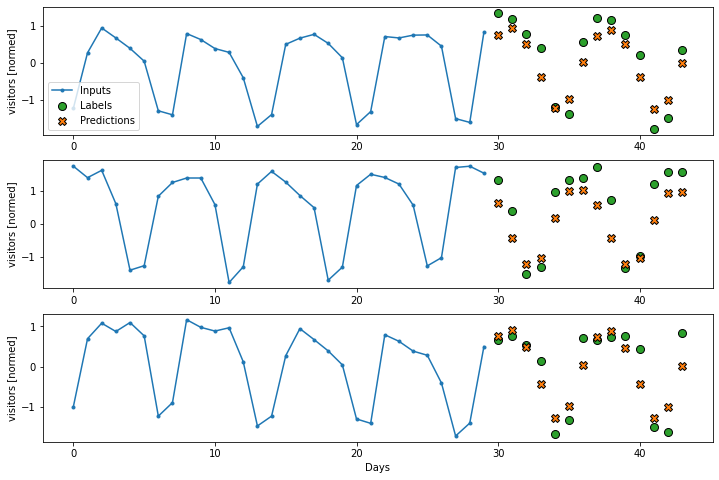

In [41]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
fit_model_and_update_stats_multi_output(multi_lstm_model, 'multi_lstm')

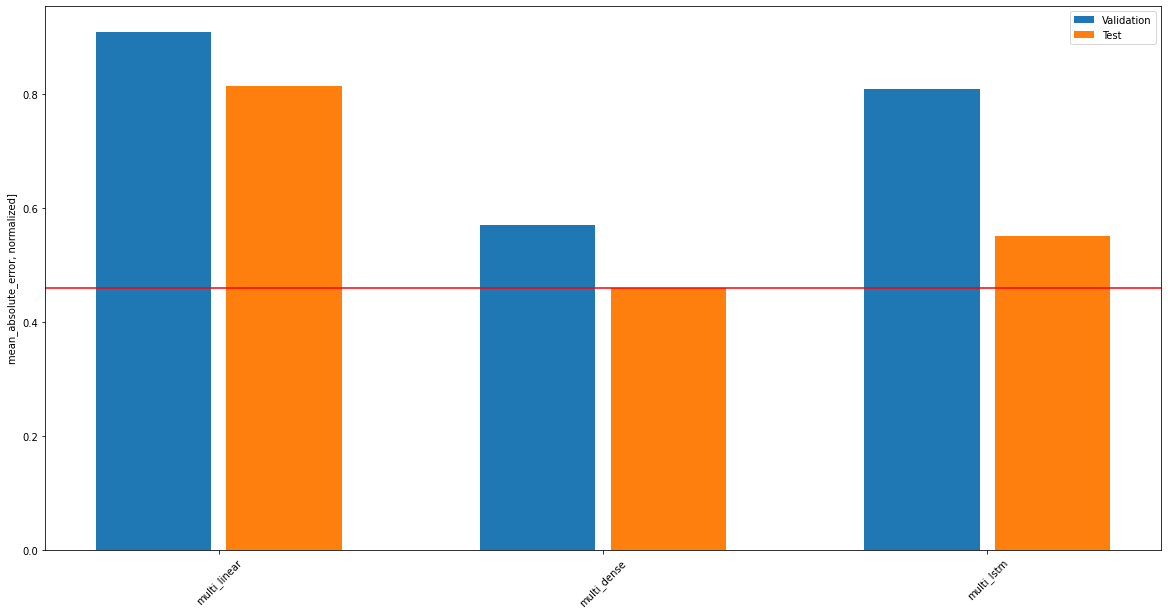

In [42]:
x = np.arange(len(performance_two_weeks))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance_two_weeks.values()]
test_mae = [v[metric_index] for v in performance_two_weeks.values()]

plt.ylabel('mean_absolute_error, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.axhline(performance_two_weeks['multi_dense'][1], c = 'red')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance_two_weeks.keys(),
           rotation=45)
_ = plt.legend()

Epoch 1/20
9/9 [==============================] - 8s 418ms/step - loss: 0.9099 - mean_absolute_error: 0.7941 - val_loss: 1.3883 - val_mean_absolute_error: 0.9121
Epoch 2/20
9/9 [==============================] - 3s 324ms/step - loss: 0.8515 - mean_absolute_error: 0.7804 - val_loss: 1.1739 - val_mean_absolute_error: 0.8448
Epoch 3/20
9/9 [==============================] - 3s 321ms/step - loss: 0.6877 - mean_absolute_error: 0.7015 - val_loss: 0.8923 - val_mean_absolute_error: 0.7753
Epoch 4/20
9/9 [==============================] - 3s 317ms/step - loss: 0.3738 - mean_absolute_error: 0.5062 - val_loss: 1.0157 - val_mean_absolute_error: 0.8326
Epoch 5/20
9/9 [==============================] - 3s 325ms/step - loss: 0.3111 - mean_absolute_error: 0.4597 - val_loss: 0.8809 - val_mean_absolute_error: 0.7720
Epoch 6/20
9/9 [==============================] - 3s 335ms/step - loss: 0.2842 - mean_absolute_error: 0.4405 - val_loss: 0.8584 - val_mean_absolute_error: 0.7579
Epoch 7/20
9/9 [============

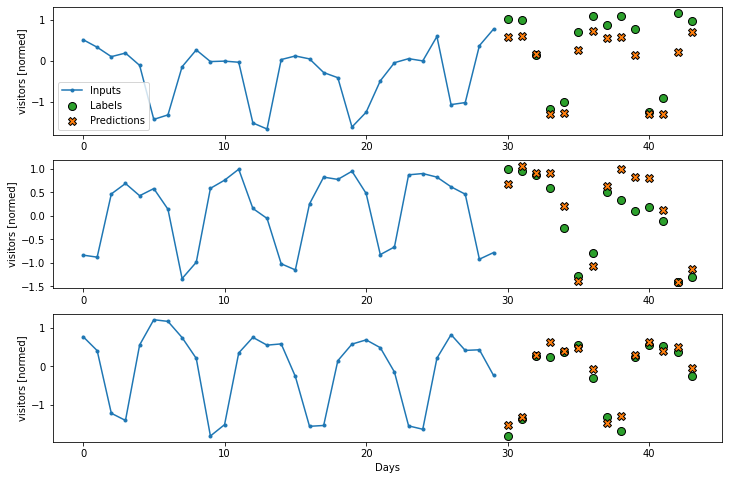

In [43]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.LSTM(256, return_sequences=False),
    tf.keras.layers.Dropout(0.4),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
fit_model_and_update_stats_multi_output(multi_lstm_model, 'multi_lstm_larger')

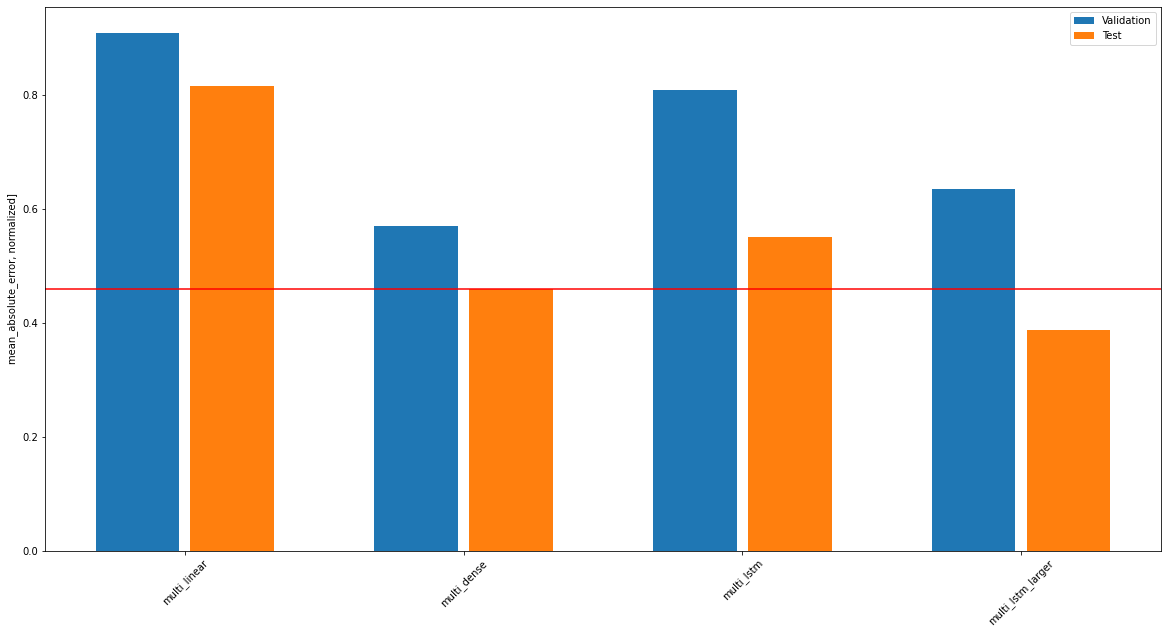

In [44]:
x = np.arange(len(performance_two_weeks))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance_two_weeks.values()]
test_mae = [v[metric_index] for v in performance_two_weeks.values()]

plt.ylabel('mean_absolute_error, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.axhline(performance_two_weeks['multi_dense'][1], c = 'red')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance_two_weeks.keys(),
           rotation=45)
_ = plt.legend()

In [45]:
## Keras tuner

In [46]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 4.1MB/s 


In [47]:
import kerastuner as kt

In [48]:
def build_model(hp):
  lstm_units = hp.Int('lstm_units', min_value=32, max_value=512, step=32)
  lstm_units_2 = hp.Int('lstm_units_2', min_value=32, max_value=512, step=32)
  dropout = hp.Float('dropout', min_value=0.0, max_value=0.6, step=0.1)
  dropout_2 = hp.Float('dropout_2', min_value=0.0, max_value=0.6, step=0.1)
  multi_lstm_model_kt = tf.keras.Sequential([
      # Shape [batch, time, features] => [batch, lstm_units]
      # Adding more `lstm_units` just overfits more quickly.
      tf.keras.layers.LSTM(lstm_units, return_sequences=True),
      tf.keras.layers.Dropout(dropout),
      tf.keras.layers.LSTM(lstm_units_2, return_sequences=False),
      tf.keras.layers.Dropout(dropout_2),
      # Shape => [batch, out_steps*features]
      tf.keras.layers.Dense(OUT_STEPS*num_features,
                            kernel_initializer=tf.initializers.zeros()),
      # Shape => [batch, out_steps, features]
      tf.keras.layers.Reshape([OUT_STEPS, num_features])
  ])

  multi_lstm_model_kt.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
  return multi_lstm_model_kt

In [49]:
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='output_dir',
                     project_name='RNN')

In [50]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [51]:
model_selection_training_window = WindowGenerator(
    input_width=30, label_width=OUT_STEPS, shift=OUT_STEPS,
    label_columns=['visitors'])
model_selection_training_window

Total window size: 44
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43]
Label column name(s): ['visitors']

In [52]:
tuner.search(model_selection_training_window.train, validation_data=model_selection_training_window.val, epochs=100, callbacks=[stop_early])

Trial 30 Complete [00h 00m 09s]
val_loss: 0.8715875148773193

Best val_loss So Far: 0.7045047879219055
Total elapsed time: 00h 06m 53s
INFO:tensorflow:Oracle triggered exit


In [53]:
models = tuner.get_best_models(num_models=2)

In [54]:
tuner.results_summary()

Results summary
Results in output_dir/RNN
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
lstm_units: 224
lstm_units_2: 192
dropout: 0.30000000000000004
dropout_2: 0.5
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.7045047879219055
Trial summary
Hyperparameters:
lstm_units: 224
lstm_units_2: 480
dropout: 0.2
dropout_2: 0.1
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 8ede51ff938d1368f66d903e9486ee14
Score: 0.7577239274978638
Trial summary
Hyperparameters:
lstm_units: 352
lstm_units_2: 448
dropout: 0.2
dropout_2: 0.0
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: b1369daa6b6d11bbc3f023896fb1af20
Score: 0.7916523218154907
Trial summary
Hyperparameters:
lstm_units: 352
lstm_units_2: 256
dropout: 0.5
dropout_2: 0.5
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: ab12e6f87355a9b5fad539b

## Anomaly detection

In [55]:
mean_absolute_error = 0.1776

(mean_absolute_error * train_std + train_mean) / 2

visitors            343.817910
day_of_week_sin       0.062948
day_of_week_cos       0.059232
day_of_month_sin      0.094080
day_of_month_cos      0.060342
is_weekend            0.182789
dtype: float64

In [56]:
def plot_with_errors(self, model=None, mean_absolute_error=0, plot_col='visitors', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=2)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=10)
        
        plt.plot(self.label_indices, predictions[n, :, label_col_index] + np.full(30, mean_absolute_error),
                    label='Prediction error 1',
                    c='#ff0000')
        
        plt.plot(self.label_indices, predictions[n, :, label_col_index] - np.full(30, mean_absolute_error),
                    label='Prediction error 2',
                    c='#00ff00')

      if n == 0:
        plt.legend()

    plt.xlabel('Days')

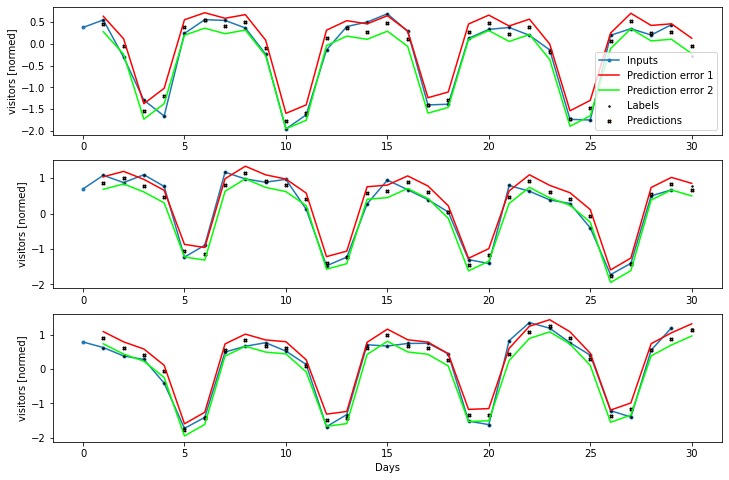

In [57]:
plot_with_errors(single_step_window, dense, mean_absolute_error = 0.1776)

In [58]:
def plot(window, model=None, plot_col='visitors'):
    inputs, labels = window.example
    plt.figure(figsize=(12, 8))
    plot_col_index = window.column_indices[plot_col]
    
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(window.input_indices, inputs[0, :, plot_col_index],
            label='Inputs', marker='.', zorder=-10)

    if window.label_columns:
      label_col_index = window.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    plt.scatter(window.label_indices, labels[0, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(window.label_indices, predictions[0, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

      plt.legend()

    plt.xlabel('Days')

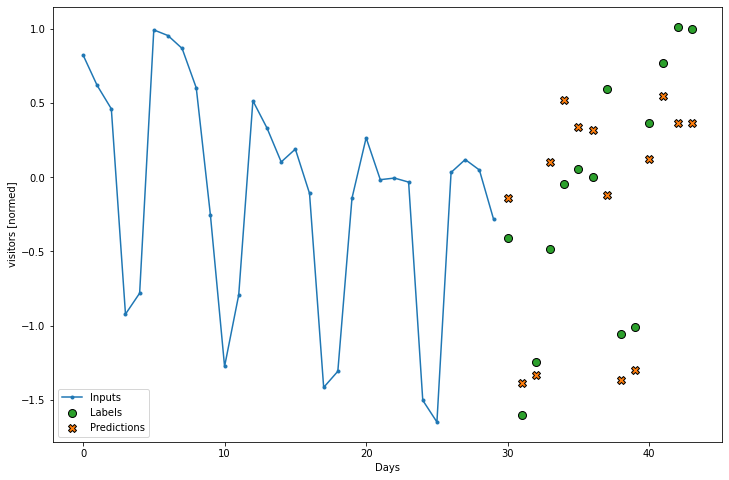

In [59]:
plot(model_selection_training_window, multi_lstm_model)